In [70]:
%%capture

!pip install razdel
!pip install rouge
!pip install --upgrade razdel nltk rouge==0.3.1 summa sumy lexrank
!rm -f meteor-1.5.tar.gz
!wget -nc https://www.cs.cmu.edu/~alavie/METEOR/download/meteor-1.5.tar.gz
!tar -xzvf meteor-1.5.tar.gz
!pip install seq2seq
!pip install datasets
!pip install pymystem3
!pip install transformers

from transformers import pipeline
import json
import random
from nltk.translate.bleu_score import corpus_bleu
import razdel
from rouge import Rouge
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter
from functools import reduce
import math
import warnings
import tensorflow as tf
import os
import re
import sys
from nltk.corpus import stopwords
from pymystem3 import Mystem
import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import subprocess
import threading

warnings.filterwarnings("ignore")

In [71]:
dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0")
dataset = dataset.remove_columns("date")
dataset = dataset.remove_columns("url")
dataset = dataset.remove_columns("title")

No config specified, defaulting to: gazeta/default
Found cached dataset gazeta (C:/Users/olya/.cache/huggingface/datasets/IlyaGusev___gazeta/default/1.0.0/ef9349c3c0f3112ca4036520d76c4bc1b8a79d30bc29643c6cae5a094d44e457)


  0%|          | 0/3 [00:00<?, ?it/s]

In [72]:
train_records = dataset['train']
val_records = dataset['test']
test_records = dataset['validation']

n_train = len(train_records)
print("Кол-во данных в обучающем множестве: ", n_train)
print("Кол-во данных в выборке валидации: ", len(val_records))
n_test = len(test_records)
print("Кол-во данных в проверочном множестве: ",n_test)

Кол-во данных в обучающем множестве:  52400
Кол-во данных в выборке валидации:  5770
Кол-во данных в проверочном множестве:  5265


In [73]:
#выведем первый элемент train_record
x_train = train_records[0]

x_train = train_records[1152]

In [74]:
n_tr = 1000
n_tst = 100
n_train=n_tr
n_test=n_tst

In [75]:
#так в наборе данных некоторые данные избыточны, то считаем только нужные нам: тексты и их саммари (аннотации)
x_train = []
for i in range(n_train):
    x_train.append(train_records[i].setdefault('text'))
    
y_train = []
for i in range(n_train):
    y_train.append('begin '+train_records[i].setdefault('summary')+' end')
    
print ("Текст: \n", x_train[0])
print("\n\n")
print ("Аннотация: \n", y_train[0])

Текст: 
 «По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожидать серьезного замедления оттока капитала на непонятно каких причинах

In [76]:
x_test = []
for i in range(n_test):
    x_test.append(test_records[i].setdefault('text'))
y_test = []
for i in range(n_test):
    y_test.append('begin '+test_records[i].setdefault('summary')+' end')
    
print ("Текст: \n ", x_test[0])
print("\n")
print ("Аннотация: \n ", y_test[0])

Текст: 
  После громких приобретений Андре Шюррле, Гуса Тиля, Эсекьеля Понсе и Джордана Ларссона , а также покупки Резиуана Мирзова московский «Спартак» не планирует закрывать свою летнюю трансферную кампанию. Красно-белые, усилив атакующую линию, взялись за укрепление центральной зоны. Особенно актуальным данный вопрос стал после ухода бразильского хавбека Фернадо в китайский «Бэйцзин Гоань». Тепень за оборонительные действия в «Спартаке» отвечают Роман Зобнин и Аяз Гулиев , однако их игра вызывает больше негативных оценок, нежели уверенности за результат. В связи с провальными переговорами с чешской «Славией» по покупке опорных полузащитников Алекса Крала и Томаша Соучека представители «народной» команды обратили свой взгляд на чемпионат Франции. Nejvyssi vedeni ruskeho klubu navstivilo v minulych dnech Ceskou republiku. I pri veskerem fotbalem respektu k vyznamu tohoto slavneho klubu Slavia odmitla vubec zahajit i zdvorilostni jednani o obou transferech. Ani jeden nyni neni na prode

In [77]:
print ("Текст: \n ", x_train[0])
print("\n")
print ("Аннотация: \n ", y_train[0])

Текст: 
  «По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожидать серьезного замедления оттока капитала на непонятно каких причина

In [78]:
nltk.download('stopwords')
print(stopwords.words("russian")) 
print(type(stopwords.words("russian")))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [79]:
stp_wrd = stopwords.words("russian")

def remove_stopword(out):
    n = len(out)
    filtered_word_list = out[:] 
    for word in out: 
        if (word in stp_wrd) or (word== ''): # or (word== '')
            filtered_word_list.remove(word) 
    return filtered_word_list

   
def data_preparation(dataset):
    #делаем все буквы строчными
    out = [x.lower() for x in dataset] 
    res = []
    #удаляем знаки препинания
    for x in out:  
        res.append (re.sub(r'[^\w\s]','', x))
    out = res
    
    b = []
    c= []
    for i in range (len(out)):
        b.append(out[i].split(' '))
        c.append(remove_stopword(b[i]))
        b[i]=" ".join(c[i])
    out = b
    return out 

#пример предподготовки данных на нескольких элементах x_train
n = 100
dataset = x_train[:n]
start_time = time.time()

out = data_preparation(dataset)
end_time = time.time() - start_time
print("Время выполнения: {:.8f} секунд " .format(end_time))



print("До подготовки данных: \n\n",x_train[0])
print("\n-----------------------------------------------------------------------------------------------------------------------------------------------------------")
print("После подготовки данных: \n\n",out[0])

Время выполнения: 0.25914001 секунд 
До подготовки данных: 

 «По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожидать серьезного з

In [80]:
start_time = time.time()

x_train = data_preparation(x_train[:n_tr])
print(n_tr, len(x_train))
y_train = data_preparation(y_train[:n_tr])
x_test = data_preparation(x_test[:n_tst])
y_test = data_preparation(y_test[:n_tst])
print(n_tst, len(y_test))
end_time = time.time() - start_time
print("Время выполнения: {:.8f} секунд " .format(end_time))

1000 1000
100 100
Время выполнения: 2.97456217 секунд 


In [81]:
print ( "len x_tr", len(x_train))
print(n_tr)
print ( "len y_tr", len(y_train),n_tr )
print(n_tr)
print ( "len x_test", len(x_test))
print(n_test)
print ( "len y_test", len(y_test),n_tst)

len x_tr 1000
1000
len y_tr 1000 1000
1000
len x_test 100
100
len y_test 100 100


In [82]:
x_tr = x_train
y_tr = y_train
x_val = x_test
y_val = y_test
print ( "len x_tr", len(x_tr))
print ( "len y_tr", len(y_tr))
print ( "len x_val", len(x_val))
print ( "len y_val", len(y_val))

len x_tr 1000
len y_tr 1000
len x_val 100
len y_val 100


In [83]:
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences

#токенизируем обучающие данные 
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))
thresh = 2  #слово считаем редким, если оно встречается меньше 2 раз

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("Редких слов в словаре :",(cnt/tot_cnt)*100, "%")

Редких слов в словаре : 52.63177013331396 %


In [84]:
text_count = []
summary_count = []

for sent in x_tr:
    text_count.append(len(sent.split()))
for sent in y_tr:
    summary_count.append(len(sent.split()))
    
print("Кол-во слов в первом предложении: ", text_count[0])

Кол-во слов в первом предложении:  293


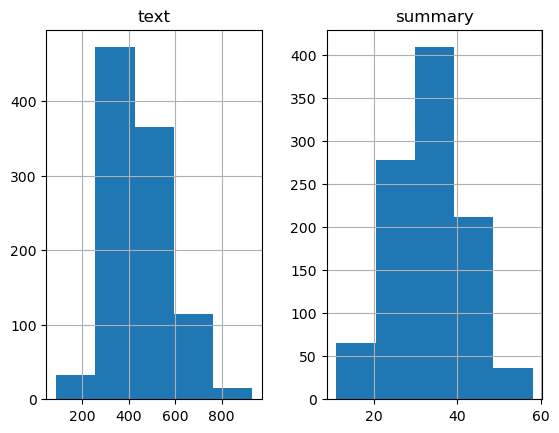

In [85]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

Кол-во слов в первом предложении:  546


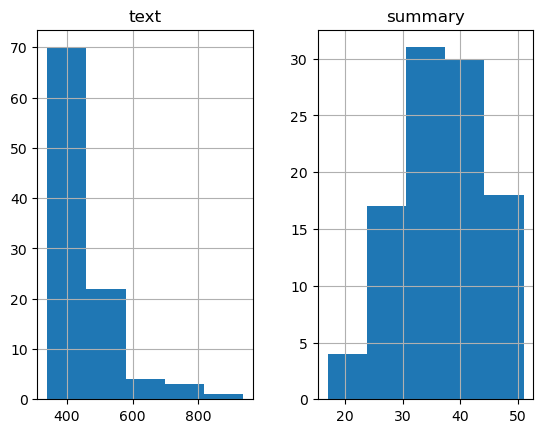

In [86]:
text_count_val = []
summary_count_val = []

for sent in x_val:
    text_count_val.append(len(sent.split()))
for sent in y_val:
    summary_count_val.append(len(sent.split()))
    
print("Кол-во слов в первом предложении: ", text_count_val[0])


graph_df= pd.DataFrame()
graph_df['text']=text_count_val
graph_df['summary']=summary_count_val

import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [87]:
cnt=0
for i in y_tr:
    if(len(i.split())<=40):
        cnt=cnt+1
print(cnt/len(y_tr))

cnt=0
for i in x_tr:
    if(len(i.split())<=600):
        cnt=cnt+1
print(cnt/len(x_tr))

0.793
0.878


In [88]:
#Модель для суммирования текста между 0-15 словами для резюме и 0-100 словами для текста

max_text_len = 200  
max_summary_len = 40
max_len_text= max_text_len  
пmax_len_summary =max_summary_len


Наиболее частые n= 100  слова :  [('это', 2341), ('года', 1828), ('также', 1585), ('россии', 1498), ('году', 1163), ('время', 949), ('который', 935), ('которые', 919), ('однако', 855), ('сша', 830), ('заявил', 721), ('лет', 662), ('словам', 662), ('очень', 652), ('млн', 607), ('будут', 539), ('сказал', 476), ('рублей', 475), ('пока', 471), ('против', 454), ('млрд', 452), ('изза', 450), ('несколько', 447), ('кроме', 447), ('страны', 443), ('ранее', 442), ('компании', 441), ('которая', 432), ('лишь', 411), ('человек', 409), ('президент', 389), ('президента', 386), ('год', 373), ('своей', 372), ('стал', 363), ('говорит', 358), ('области', 355), ('около', 347), ('именно', 347), ('глава', 343), ('россия', 339), ('1', 338), ('стороны', 338), ('мира', 335), ('первый', 334), ('власти', 333), ('могут', 333), ('газетеru', 333), ('момент', 330), ('случае', 328), ('которых', 326), ('решение', 325), ('дело', 322), ('украины', 322), ('день', 320), ('является', 319), ('команды', 317), ('второй', 316

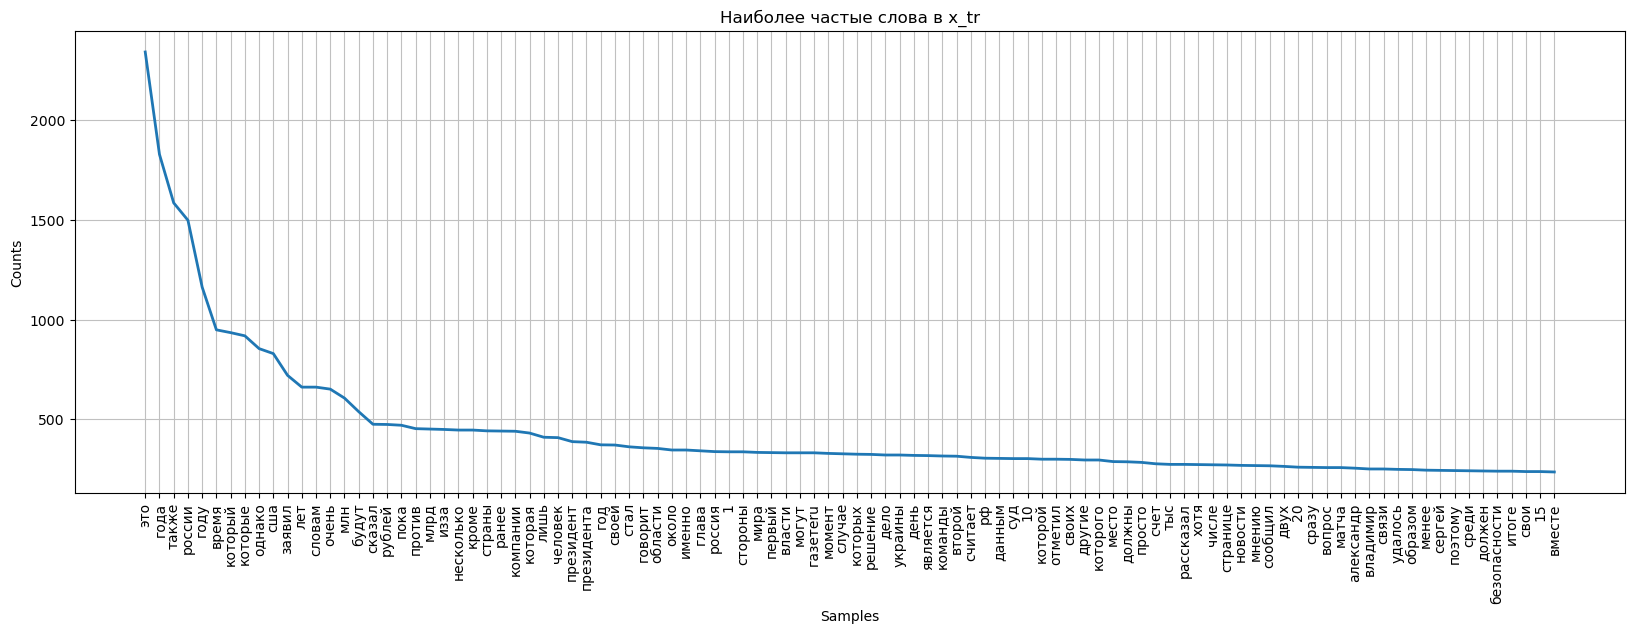

Наиболее частые слова:  ['это', 'года', 'также', 'россии', 'году', 'время', 'который', 'которые', 'однако', 'сша', 'заявил', 'лет', 'словам', 'очень', 'млн', 'будут', 'сказал', 'рублей', 'пока', 'против', 'млрд', 'изза', 'несколько', 'кроме', 'страны', 'ранее', 'компании', 'которая', 'лишь', 'человек', 'президент', 'президента', 'год', 'своей', 'стал', 'говорит', 'области', 'около', 'именно', 'глава', 'россия', '1', 'стороны', 'мира', 'первый', 'власти', 'могут', 'газетеru', 'момент', 'случае', 'которых', 'решение', 'дело', 'украины', 'день', 'является', 'команды', 'второй', 'считает', 'рф', 'данным', 'суд', '10', 'которой', 'отметил', 'своих', 'другие', 'которого', 'место', 'должны', 'просто', 'счет', 'тыс', 'рассказал', 'хотя', 'числе', 'странице', 'новости', 'мнению', 'сообщил', 'двух', '20', 'сразу', 'вопрос', 'матча', 'александр', 'владимир', 'связи', 'удалось', 'образом', 'менее', 'сергей', 'поэтому', 'среди', 'должен', 'безопасности', 'итоге', 'свои', '15', 'вместе']


In [89]:
def most_frequent_word(test_list, number_of_words):
    all_words = reduce(lambda a, b: a + b, [sub.split() for sub in test_list])
    word_counts = Counter(all_words)
    word_frequency = nltk.FreqDist(all_words) #получает частотное распределение для каждого токена
    print("\nНаиболее частые n=",number_of_words, " слова : ", word_frequency.most_common(number_of_words))
    fig = plt.figure(figsize=(20, 6))
    plt.xlabel("Слово")
    plt.ylabel("Частота встречаемости в dataset")
    most_popular = [item[0] for item in word_frequency.most_common(number_of_words)]
    word_frequency.plot(number_of_words, title='Наиболее частые слова в x_tr')
    return word_frequency.most_common(number_of_words), most_popular 
 
test_list = x_tr
number_of_most_popular_words = math.ceil(0.1*n_tr)
word_frequency, x_tr_most_popular = most_frequent_word(test_list, number_of_most_popular_words)
print("Наиболее частые слова: ", x_tr_most_popular)

In [90]:
#токенизируем 
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)#Tokenizer будет использовать самые популярные слова, но в то же время вести счетчик всех слов 
x_tokenizer.fit_on_texts(list(x_tr)) #Обновляет внутренний словарь на основе списка текстов.

#Преобразует каждый текст в текстах в последовательность целых чисел
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#заполенение нулями до максимальной длины
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#размер словаря
x_voc   =  x_tokenizer.num_words + 1
print("Размер словаря x_voc", x_voc)

Размер словаря x_voc 81710


In [91]:
print(x_tr[0])

[ 2110  3279  8868  1340    21 11407  1855 11408 15998 15997  1217  3605
  4258  5171    36   237  2414 39125 39126  2619 19804   169   593  6558
  1217 39127 11409  1033  8869   112  2965  7190 26068   460 15999 15997
   371 39128  3793 19805  6015   237  2414  6560  3794    87  9985 39129
  1911  6558  1217   409  3280   169    82    12  6016    29   461     5
   673 39130  1585   859 39131   609 39132    21 39133   347    33     4
 26069 26070    21   237  3281 11410 15997  1217   120     5 26071  4822
  2325  3282   214  9986   947    58  7191 16000     1  3606 26072   205
 39134  4502 26073  5582    50   388  7191  7946 19806    41   242   409
 19807   144    36 19804   242  1912 13331  1691 16001  9987  6561   673
  4823  6017 26074  1034  6562   202  9988   155 39135   277 26075 39136
  8870    36  9985  1276    25   288  5172  6018  1692 39137  1217   356
  1401   202  7947    14  2966 26076   462    33   371   673   117   144
  1341   879   737   202  1913 11411  5173   351 26

In [92]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 0 

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

y_voc  =   y_tokenizer.num_words +1
print("Размер словаря y_voc", y_voc)

#проверка, что токенов начало и конец столько же, сколько и строк
print (y_tokenizer.word_counts['begin'],len(y_tr) ) 
print (y_tokenizer.word_counts['end'],len(y_tr) )

Размер словаря y_voc 15285
1000 1000
1000 1000


In [93]:
latent_dim = max_len_text
embedding_dim= 600 #200 #200 размер каждого вложенного вектора, прошедшего через слой вложения
max_text_len = max_len_text

# Слой Input кодировщика
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding слой
#Преобразоывает положительныев целые числа (индексы) в плотные (dense) векторы фиксированного размера
#Этот слой может использоваться только как первый слой в модели.
#e = Embedding(input_dim - размерность словаря исходных данных, output_dim- Это размер векторного пространства, в которое будут вставлены слова, input_length=50
#input_length: Это длина входных последовательностей, как  могли бы определить для любого входного слоя модели Keras

enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs) #inplength

# 1 слой LSTM Long Short-Term Memory layer
encoder_lstm1 = LSTM(latent_dim, #Положительное целое число, размерность выходного пространства 
                     return_sequences=True, #Возвращать ли последний вывод. в выходной последовательности или в полной последовательности. По умолчанию: False.
                     return_state=True, #Следует ли возвращать последнее состояние в дополнение к выходным данным. По умолчанию: False.
                     dropout=0.4,  #Доля единиц, отбрасываемая при линейном преобразовании входных данных. По умолчанию: 0. Используется для борьбы с переобучением
                     recurrent_dropout=0.4) # Доля единиц, которую нужно отбросить для линейного преобразования рекуррентного состояния. По умолчанию: 0.
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# 2 слой LSTM
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# 3 слой LSTM
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Настройка декодер, используя encoder_states в качестве начального состояния
decoder_inputs = Input(shape=(None, ))

# Embedding слой (слой встраивания)
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer 
#Эта оболочка позволяет применять слой к каждому временному фрагменту ввода.
#Каждый вход должен быть как минимум трехмерным, и размер первого индекса первого входа будет считаться временным измерением.
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# определение модели
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 600)     49026000    ['input_9[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  [(None, 200, 200),   640800      ['embedding_2[0][0]']            
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                            

In [94]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics = ['accuracy']) # Компиляция
print("Модель скомпилировалась")
print(x_tr.shape)
print(y_tr.shape)
history = model.fit(          # Обучение модели
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs = 10,
    batch_size=32, #32
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], 
                                   y_val.shape[1], 1)[: , 1:]),
    )

Модель скомпилировалась
(1000, 200)
(1000, 40)
Epoch 1/10
32/32 [==============================] - 519s 15s/step - loss: 8.5906 - accuracy: 0.1956 - val_loss: 5.9707 - val_accuracy: 0.3900
Epoch 2/10
32/32 [==============================] - 486s 15s/step - loss: 7.6524 - accuracy: 0.2013 - val_loss: 5.7200 - val_accuracy: 0.3900
Epoch 3/10
32/32 [==============================] - 525s 16s/step - loss: 7.4003 - accuracy: 0.2015 - val_loss: 5.3624 - val_accuracy: 0.3926
Epoch 4/10
32/32 [==============================] - 525s 16s/step - loss: 7.2713 - accuracy: 0.2198 - val_loss: 5.3221 - val_accuracy: 0.4154
Epoch 5/10
32/32 [==============================] - 623s 19s/step - loss: 7.1937 - accuracy: 0.2276 - val_loss: 5.2828 - val_accuracy: 0.4151
Epoch 6/10
32/32 [==============================] - 702s 22s/step - loss: 7.1384 - accuracy: 0.2284 - val_loss: 5.2877 - val_accuracy: 0.4169
Epoch 7/10
32/32 [==============================] - 730s 23s/step - loss: 7.0903 - accuracy: 0.2288 -

In [95]:
# Сохраним результат обучения на гугл диск
from google.colab import drive
drive.mount('/content/gdrive')

history.model.save("/content/gdrive/My Drive/seq2seq_model.h5") # Вставить свой путь

ModuleNotFoundError: No module named 'google.colab'

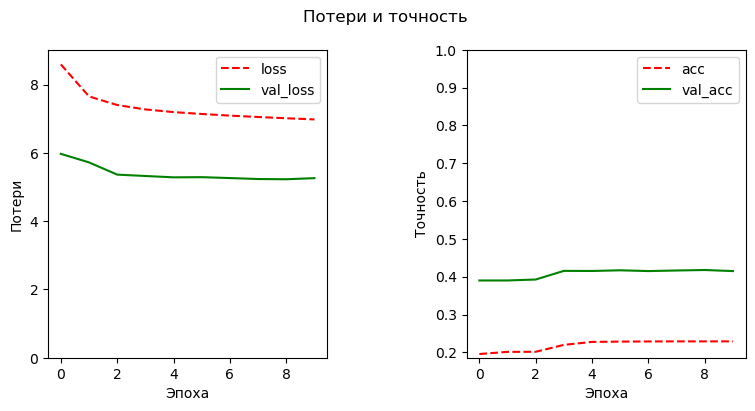

In [96]:
import matplotlib.pyplot as plt
def one_plot(n, y_lb, loss_acc, val_loss_acc):
    plt.subplot(1, 2, n)
    if n == 1:
        lb, lb2 = 'loss', 'val_loss'
        yMin = 0
        yMax = 1.05 * max(max(loss_acc), max(val_loss_acc))
    else:
        lb, lb2 = 'acc', 'val_acc'
        yMin = min(min(loss_acc), min(val_loss_acc))
        yMax = 1.0
    plt.plot(loss_acc, color = 'r', label = lb, linestyle = '--')
    plt.plot(val_loss_acc, color = 'g', label = lb2)
    plt.ylabel(y_lb)
    plt.xlabel('Эпоха')
    plt.ylim([0.95 * yMin, yMax])
    plt.legend()

def BuildPlot(history):
    plt.figure(figsize=(9, 4))
    plt.subplots_adjust(wspace=0.5)
    one_plot(1, 'Потери', history['loss'], history['val_loss'])
    one_plot(2, 'Точность', history['accuracy'], history['val_accuracy'])
    plt.suptitle('Потери и точность')
    plt.show()


BuildPlot(history.history)

In [97]:
dict_ind_sum = y_tokenizer.index_word  # словарь соответствия индекс - токен в summary
dict_ind_text = x_tokenizer.index_word # словарь соответствия индекс - токен в text
dict_sum_ind = y_tokenizer.word_index  # словарь соответствия токен в summary-его индекс
# Модель вывода
# Кодируем входную последовательность, чтобы получить вектор признаков
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Настраиваем декодировщик

# тензоры сохранят состояния предыдущего временного шага.
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Получить вложения последовательности декодера
dec_emb2 = dec_emb_layer(decoder_inputs)

# Чтобы предсказать следующее слово в последовательности, устанавливаем в начальные состояния состояния с предыдущего временного шага
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#слой softmax для генерации по целевому словарю 
decoder_outputs2 = decoder_dense(decoder_outputs2)

# модель декодировщика
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [98]:
def decode_sequence(input_seq):
    # предсказания
    e_out, e_h, e_c = encoder_model.predict(input_seq)
#     print("inp_seq", input_seq)
#     print(type(e_out))
#     print(e_h)
    # Генерация пустой целевой последовательности 
    target_seq = np.zeros((1,1), dtype=int)
    # Первое слово - begin
    target_seq[0, 0] = dict_sum_ind['begin']
    #print(target_seq[0, 0])
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        #output_tokens, h, c = decoder_model.predict([target_seq] +[e_out, e_h, e_c]) 
        output_tokens, h, c = decoder_model.predict_on_batch([target_seq] +[e_out, e_h, e_c]) 
         # Индекс токена как индекс наибольшего элемента массива output_tokens
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         print(output_tokens[0][0][0])- трехмерный массив с числами с числами в районе 0.02
        #print("\n\n", output_tokens[0, -1, :])
#       
        sampled_token = dict_ind_sum[sampled_token_index]
        #print("-------------- ",sampled_token_index,sampled_token) # 
    
    
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

        # Выход из цикла
        if (sampled_token == 'end'  or len(decoded_sentence.split()) >= (max_summary_len-1)) : #or (sampled_token_index==0))
            stop_condition = True

        # Обновление целевой последовательности
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # обновление внутреннего состояния
        #print(e_h, e_c )
        e_h, e_c = h, c

    return decoded_sentence

In [99]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=dict_sum_ind['begin']) and i!=dict_sum_ind['end']):
            newString=newString+ dict_ind_sum[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+dict_ind_text[i]+' '
    return newString

In [100]:
# %%capture
# Если убрать %%capture будет виден результат суммаризации моделью, вывод большой, поэтому скрыл.

for i in range(10):
    print ("Кол-во символов в строке: \t", len(seq2text(x_val[i])),"\n", "Текст: \n",seq2text(x_tr[i]))
    print ('\n\n Ожидаемый результат: \n',  seq2summary(y_val[i])) 
    print ('\n\n Полученная на основе НС аннотация текста :', decode_sequence(x_val[i].reshape(1,max_text_len))) # НС - нейросеть
    print( "-------------")

Кол-во символов в строке: 	 1588 
 Текст: 
 изменить оценку настаивать 70 млрд означало ожидать серьезного замедления оттока капитала непонятно каких причинах говорит главный экономист bnp paribas юлия цепляева последние месяца отток капитала ускорится декабрь приходится значительная часть выплат внешним долгам приводит усилению оттока особенно рефинансируются новыми кредитами соглашается главный экономист фк открытие владимир тихомиров прогнозируемый минэкономразвития отток капитала самых высоких последние 20 лет ушло лишь 2008 году фоне разрастания финансового кризиса российскогрузинской войны 1337 млрд кризисный 2009 год россии утекло 561 млрд главный фактор ускорения оттока капитала 2011 году нестабильность внешних финансовых рынках рост опасений относительно второй волны рецессии это реакция неуверенность которую генерирует европа долговыми проблемами случае новой волны глобальной турбулентности россия одна самых уязвимых стран говорит цепляева одна причина ослабление рубля привле

In [ ]:
# Расчет метрик

class Meteor:
    def __init__(self, meteor_jar, language):
        # Used to guarantee thread safety
        self.lock = threading.Lock()

        self.meteor_cmd = ['java', '-jar', '-Xmx2G', meteor_jar, '-', '-', '-stdio', '-l', language, '-norm']
        self.meteor_p = subprocess.Popen(self.meteor_cmd,
                                         stdin=subprocess.PIPE,
                                         stdout=subprocess.PIPE,
                                         stderr=subprocess.STDOUT,
                                         encoding='utf-8',
                                         bufsize=0)

    def compute_score(self, hyps, refs):
        scores = []
        self.lock.acquire()
        for hyp, ref in zip(hyps, refs):
            stat = self._stat(hyp, ref)
            # EVAL ||| stats
            eval_line = 'EVAL ||| {}'.format(" ".join(map(str, map(int, map(float, stat.split())))))
            self.meteor_p.stdin.write('{}\n'.format(eval_line))
            scores.append(float(self.meteor_p.stdout.readline().strip()))
        self.lock.release()

        return sum(scores) / len(scores)

    def _stat(self, hypothesis_str, reference_list):
        # SCORE ||| reference 1 words ||| reference n words ||| hypothesis words
        hypothesis_str = hypothesis_str.replace('|||', '').replace('  ', ' ')
        score_line = ' ||| '.join(('SCORE', ' ||| '.join(reference_list), hypothesis_str))
        self.meteor_p.stdin.write('{}\n'.format(score_line))
        return self.meteor_p.stdout.readline().strip()

    def __del__(self):
        self.lock.acquire()
        self.meteor_p.stdin.close()
        self.meteor_p.kill()
        self.meteor_p.wait()
        self.lock.release()

In [ ]:
def calc_metrics(refs, hyps, language, metric="all", meteor_jar=None):
    metrics = dict()
    metrics["count"] = len(hyps)
    metrics["ref_example"] = refs[-1]
    metrics["hyp_example"] = hyps[-1]
    many_refs = [[r] if r is not list else r for r in refs]
    if metric in ("bleu", "all"):
        metrics["bleu"] = corpus_bleu(many_refs, hyps)
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(hyps, refs, avg=True)
        metrics.update(scores)
    if metric in ("meteor", "all") and meteor_jar is not None and os.path.exists(meteor_jar):
        meteor = Meteor(meteor_jar, language=language)
        metrics["meteor"] = meteor.compute_score(hyps, many_refs)
    return metrics


def print_metrics(refs, hyps, language, metric="all", meteor_jar=None):
    metrics = calc_metrics(refs, hyps, language=language, metric=metric, meteor_jar=meteor_jar)

    print("-------------METRICS-------------")
    print("Count:\t", metrics["count"])
    print("Ref:\t", metrics["ref_example"])
    print("Hyp:\t", metrics["hyp_example"])

    if "bleu" in metrics:
        print("BLEU:     \t{:3.1f}".format(metrics["bleu"] * 100.0))
    if "rouge-1" in metrics:
        print("ROUGE-1-F:\t{:3.1f}".format(metrics["rouge-1"]['f'] * 100.0))
        print("ROUGE-2-F:\t{:3.1f}".format(metrics["rouge-2"]['f'] * 100.0))
        print("ROUGE-L-F:\t{:3.1f}".format(metrics["rouge-l"]['f'] * 100.0))
    if "meteor" in metrics:
        print("METEOR:   \t{:3.1f}".format(metrics["meteor"] * 100.0))

In [ ]:
def postprocess(refs, hyps, tokenize_after=True, lower=True):
    for i, (ref, hyp) in enumerate(zip(refs, hyps)):
        ref = ref.strip()
        hyp = hyp.strip()
        if tokenize_after:
            hyp = " ".join([token.text for token in razdel.tokenize(hyp)])
            ref = " ".join([token.text for token in razdel.tokenize(ref)])
        if lower:
            hyp = hyp.lower()
            ref = ref.lower()
        refs[i] = ref
        hyps[i] = hyp
    return refs, hyps

In [ ]:
def calc_method_score(records, predict_func, nrows=None):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if nrows is not None and i >= nrows:
            break
        summary = record["summary"]
        text = record["text"]
        prediction = predict_func(text, summary)
        references.append(summary)
        predictions.append(prediction)
    references, predictions = postprocess(references, predictions)
    print_metrics(references, predictions, "ru", meteor_jar="meteor-1.5/meteor-1.5.jar")

In [ ]:
summary = test_records["summary"][0]
text = test_records["text"][0]
prediction=predict_func(text, summary)
prediction

In [ ]:
def predict_lead(text, summary, n):
    sentences = [sentence.text for sentence in razdel.sentenize(text)]
    prediction = " ".join(sentences[:n])
    return prediction

In [ ]:
# Метрики по модели

calc_method_score(test_records, lambda x, y: predict_lead(x, y, 3))

In [ ]:
test_records['text'][0]

In [ ]:
test_records['summary'][0]

In [ ]:
predict_lead(test_records['text'][0], test_records['summary'][0], 6)

In [102]:
# Для быстрого вывода суммаризации можно рассмотреть следующий алгоритм seq2seq

summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

ResourceExhaustedError: Exception encountered when calling layer 'encoder' (type TFBartEncoder).

{{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[50264,1024] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Mul]

Call arguments received by layer 'encoder' (type TFBartEncoder):
  • input_ids=tf.Tensor(shape=(3, 5), dtype=int32)
  • inputs_embeds=None
  • attention_mask=tf.Tensor(shape=(3, 5), dtype=int32)
  • head_mask=None
  • output_attentions=False
  • output_hidden_states=False
  • return_dict=True
  • training=False

In [ ]:
# article любая новость, модель обучена на русском

article = """В Тюмени поезд Новый Уренгой – Москва насмерть сбил двоих человек. Погибла девушка и неизвестный мужчина, сообщает Уральская транспортная прокуратура. ЧП случилось 25 апреля 2023 года.

«На 2136 км пикет 8 в городе Тюмень в результате наезда пассажирского поезда произошло смертельное травмирование двух лиц: девушки 1992 г.р. и неизвестного мужчины, личность которого устанавливается»,– рассказали в ведомстве.

Обстоятельства произошедшего устанавливаются."""


In [ ]:
summary = summarizer(article, max_length=130, min_length=30)

In [ ]:
summary